In [14]:
import urllib.request
import json
import re
import sqlite3
from datetime import datetime
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import operator
from wordcloud import WordCloud


token = ''  # need to obtain Service token
owner_id = -84793390  # Академия Яндекса

a = 'https://api.vk.com/method/'
b = 'wall.get?'
b2 = 'wall.getComments?'
c = 'owner_id=%i&offset=%i&count=%i&v=5.92&access_token=%s'
c2 = 'post_id=%i&owner_id=%i&offset=%i&count=%i&v=5.92&access_token=%s'

conn = sqlite3.connect('hw6_data.db')
c1 = conn.cursor()

In [15]:
def get_stop_words_from_file(file_local):
    stop_words = list([])
    f = open(file_local, 'r', encoding='utf-8')
    f1 = f.readlines()
    for x in f1:
        stop_words.append(x.split('\n')[0])

    return stop_words

In [16]:
def get_sex_by_user_id(user_id):
    # 0 - None, 1 - female, 2 - male
    part_1 = 'https://api.vk.com/method/users.get?'
    part_2 = 'v=%s&access_token=%s&user_ids=%s&fields=sex'
    if user_id <= 0:
        return -1
    version = 5.92
    req = urllib.request.Request(part_1 + part_2 % (version, token, user_id))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    sex = -1
    if 'sex' in (data['response'][0]):
        sex = data['response'][0]['sex']
    return sex

In [17]:
def get_is_private_name_sex_by_user_id(user_id):

    version = 5.92
    part_1 = 'https://api.vk.com/method/users.get?'
    part_2 = 'v=%s&access_token=%s&user_ids=%s&fields=sex'
    req = urllib.request.Request(part_1 + part_2 % (version, token, user_id))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    is_private = 0
    if 'deactivated' in data['response'][0]:
        is_private = 0
    elif data['response'][0]['is_closed'] is True:
        is_private = 1
    name = data['response'][0]['first_name'] + ' '
    name = name + data['response'][0]['last_name']
    sex = -1
    if 'sex' in (data['response'][0]):
        sex = data['response'][0]['sex']
    return is_private, name, sex

In [18]:
def get_number_of_friends_by_id(user_id):

    if user_id < 0:
        return - 1
    version = 5.92
    part_1 = 'https://api.vk.com/method/friends.get?'
    part_2 = 'v=%s&access_token=%s&user_id=%s'
    req = urllib.request.Request(part_1 + part_2 % (version, token, user_id))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    if 'response' not in data:
        return -1
    return data['response']['count']

In [19]:
def get_posts(how_many):
        count = 0
        r = how_many % 100
        local_posts = {}
        i = 0
        while i < how_many//100:
            p1 = a + b + c
            req = urllib.request.Request(p1 % (owner_id, 100*i, 100, token))
            response = urllib.request.urlopen(req)
            result = response.read().decode('utf-8')
            data1 = json.loads(result)
            data_length = len(data1['response']['items'])

            for j in range(min(100, data_length)):
                local_posts[j+100*i] = data1['response']['items'][j]

            count = i + 1
            i = i + 1
            if data_length < 100:
                i = how_many
                r = 0

        if r > 0:
            p2 = a + b + c
            req = urllib.request.Request(p2 % (owner_id, 100*count, r, token))
            response = urllib.request.urlopen(req)
            result = response.read().decode('utf-8')
            data1 = json.loads(result)

            for i in range(r):
                local_posts[i+100*count] = data1['response']['items'][i]

        return local_posts

In [20]:
def get_thread_comments(local_comments, main_comment, offset):
    c_id = main_comment["id"]
    count_thread = main_comment["thread"]["count"]

    count = 0
    for i in range(count_thread//100):
        p1 = 'https://api.vk.com/method/wall.getComments?'
        p2 = 'comment_id=%i&owner_id=%i&offset=%i&'
        p3 = p1 + p2 + 'count=100&v=5.92&access_token=%s'
        req1 = urllib.request.Request(p3 % (c_id, owner_id, 100*count, token))
        response1 = urllib.request.urlopen(req1)
        result1 = response1.read().decode('utf-8')
        data3 = json.loads(result1)

        for j in range(100):
            t1 = "This comment has been deleted"
            t2 = data3['response']['items'][j]["id"]
            t3 = "user_id"
            t4 = "text"
            if "deleted" in data3['response']['items'][j]:
                local_comments[offset+i*count+j] = {t4: t1, t3: -1, 'id': t2}
            else:
                t5 = data3['response']['items'][j]["text"]
                t6 = data3['response']['items'][j]["from_id"]
                local_comments[offset+i*count+j] = {t4: t5, t3: t6, 'id': t2}
        count += 1

    rg = count_thread % 100
    p4 = 'https://api.vk.com/method/wall.getComments?comment_id=%i'
    p5 = '&owner_id=%i&offset=%i&count=%i&v=5.92&access_token=%s'
    n8 = 100*count
    req1 = urllib.request.Request(p4 + p5 % (c_id, owner_id, n8, rg, token))
    response1 = urllib.request.urlopen(req1)
    result1 = response1.read().decode('utf-8')
    data3 = json.loads(result1)
    for j in range(rg):
        s1 = "text"
        s2 = "This comment has been deleted"
        s3 = "user_id"
        s4 = data3['response']['items'][j]["id"]
        s5 = data3['response']['items'][j]["text"]
        s6 = data3['response']['items'][j]["from_id"]
        if "deleted" in data3['response']['items'][j]:
            local_comments[offset+100*count+j] = {s1: s2, s3: -1, 'id': s4}
        else:
            local_comments[offset+100*count+j] = {s1: s5, s3: s6, 'id': s4}

    return local_comments

In [21]:
def get_comments(post_local):
    count = 0
    local_comments = {}
    post_id = post_local["id"]
    number_of_comments = post_local['comments']['count']
    r = number_of_comments % 100

    for i in range(number_of_comments//100):
        p1 = a + b2 + c2
        l = 100*i
        req = urllib.request.Request(p1 % (post_id, owner_id, l, 100, token))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data2 = json.loads(result)

        for j in range(100):
            s1 = "text"
            s2 = "This comment has been deleted"
            s3 = "user_id"
            s4 = data2['response']['items'][j]["id"]
            if "deleted" in data2['response']['items'][j]:
                local_comments[j+100*i] = {s1: s2, s3: -1, 'id': s4}
            else:
                s5 = data2['response']['items'][j]["text"]
                s6 = data2['response']['items'][j]["from_id"]
                local_comments[j+100*i] = {s1: s5, s3: s6, 'id': s4}

            n = data2["response"]['items'][j]["thread"]["count"]
            if n > 0:
                s7 = local_comments
                s8 = data2["response"]['items'][j]
                local_comments = get_thread_comments(s7, s8, j+100*i + 1)
                j += n

        count = i + 1

    if r > 0:
        j1 = a + b2 + c2
        i1 = 100*count
        req = urllib.request.Request(j1 % (post_id, owner_id, i1, r, token))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data2 = json.loads(result)
        k, j = 0, 0

        while j < r:
            s1 = "text"
            s2 = "This comment has been deleted"
            s3 = "user_id"
            s4 = data2['response']['items'][k]["id"]
            if "deleted" in data2['response']['items'][k]:
                local_comments[100*count + j] = {s1: s2, s3: -1, 'id': s4}
            else:
                s5 = data2['response']['items'][k]["text"]
                s6 = data2['response']['items'][k]["from_id"]
                local_comments[100*count + j] = {s1: s5, s3: s6, 'id': s4}

            n = data2["response"]['items'][k]["thread"]["count"]
            if n > 0:
                u1 = data2["response"]['items'][k]
                e1 = 100*count + j + 1
                local_comments = get_thread_comments(local_comments, u1, e1)
                j += n
            k += 1
            j += 1

    for k in range(len(local_comments)):
        t111 = local_comments[k]['text']
        local_comments[k]['text'] = re.sub(r'\[id\d+\|', '', t111)

    return local_comments

In [22]:
def get_post_or_comment_length(text_local):
    length = 0
    if text_local != "This comment has been deleted":
        length = len(re.compile('\w+').findall(text_local))
    return length

In [23]:
def get_average_comments_lengths(local_comments):
    length_of_comments = 0
    how_many_comments = len(local_comments)
    for i in range(len(local_comments)):
        if local_comments[i][3] != "This comment has been deleted":
            lc = local_comments[i][3]
            length_of_comments += len(re.compile('\w+').findall(lc))
        else:
            how_many_comments -= 1

    average_length_of_comments = 0
    if how_many_comments > 0:
        average_length_of_comments = length_of_comments/how_many_comments

    return average_length_of_comments

In [24]:
def get_time_of_post_in_hours(unix_time):
    utc = datetime.fromtimestamp(unix_time)
    hours_24_format = (utc.hour*3600 + utc.minute*60 + utc.second)/3600
    return hours_24_format

In [25]:
def get_post_weekday(post_local):
    unixtime = post_local['date']
    utc = datetime.fromtimestamp(unixtime)
    post_weekday = datetime.weekday(utc)  # 0 - monday
    return post_weekday + 1  # 1 - monday

In [26]:
def get_data_from_file():

    file_local_1 = open("data_unlemmatized.txt", "r", encoding='utf-8')
    texts_local = file_local_1.read()
    file_local_1.close()

    return texts_local

In [27]:
def save_lemmatized_data(texts_local):
    m = Mystem()
    file_local = open("data_lemmatized.txt", "w", encoding='utf-8')
    file_local.write('')
    file_local.close()

    file_local = open("data_lemmatized.txt", "a", encoding='utf-8')
    text = ''
    count = 0
    for line_local in texts_local.split('\n'):
        text = text + line_local + ' '
        if count > 10:
            lemma = m.lemmatize(text)
            file_local.write(''.join(lemma))
            text = ''
            count = 0
        count += 1

    lemma = m.lemmatize(text)
    file_local.write(''.join(lemma))
    file_local.close()

In [28]:
def save_posts_data_to_database(posts_local):
    file_for_rewriting = open("data_lemmatized.txt", "w", encoding='utf-8')
    file_for_rewriting.write('')
    file_for_rewriting.close()

    file_for_rewriting = open("data_unlemmatized.txt", "w", encoding='utf-8')
    file_for_rewriting.write('')
    file_for_rewriting.close()

    file_local = open('data_unlemmatized.txt', "a", encoding='utf-8')

    s1 = 'INSERT INTO posts VALUES (?, ?, ?, ?, ?, ?)'
    for i in range(len(posts_local)):
        post_id = posts_local[i]['id']
        owner_id_local = posts_local[i]['owner_id']
        day = get_post_weekday(posts_local[i])
        c_count = posts_local[i]['comments']['count']
        text = posts_local[i]['text']
        file_local.write(text + '\n')
        p_date = posts_local[i]['date']
        c1.execute(s1, (post_id, owner_id_local, day, c_count, text, p_date))
        conn.commit()

    file_local.close()

In [29]:
def save_comments_data_to_database(posts_local):
    file_local = open("data_unlemmatized.txt", "a", encoding='utf-8')

    s1 = 'INSERT INTO comments VALUES (?, ?, ?, ?)'
    for i in range(len(posts_local)):
        comments_local = get_comments(posts_local[i])
        for j in range(len(comments_local)):
            c_id = comments_local[j]['id']
            user_id = comments_local[j]['user_id']
            post_id = posts_local[i]['id']
            text = comments_local[j]['text']
            file_local.write(text + '\n')
            c1.execute(s1, (c_id, user_id, post_id, text))
            conn.commit()
            if user_id > 0:
                save_users_data_to_database(user_id)

    file_local.close()

In [30]:
def save_users_data_to_database(user_id):
    c1.execute('SELECT * FROM users WHERE user_id = ' + str(user_id))
    s1 = 'INSERT INTO users VALUES (?, ?, ?, ?, ?)'
    if c1.fetchone() is None and user_id > 0:
        is_private, name, sex = get_is_private_name_sex_by_user_id(user_id)
        nf = get_number_of_friends_by_id(user_id)
        c1.execute(s1, (user_id, is_private, name, sex, nf))
        conn.commit()

In [31]:
def graph_1_posts_and_comments_lengths(posts_local):

    len_posts = len(posts_local)
    data_x_y = [{}]*len_posts
    s1 = 'SELECT * FROM comments WHERE post_id = '
    for h in range(len_posts):
        c1.execute(s1 + str(posts_local[h][0]))
        comments_local = c1.fetchall()
        x = get_post_or_comment_length(posts_local[h][4])
        y = get_average_comments_lengths(comments_local)
        data_x_y[h] = {'x': x, 'y': y}

    data_x_y = sorted(data_x_y, key=lambda k: k['x'])
    X = [0]*len_posts
    Y = [0]*len_posts

    for i in range(len_posts):
        X[i] = data_x_y[i]['x']
        Y[i] = data_x_y[i]['y']

    plt.scatter(X, Y, s=30, c="#ceaefa", marker="o")
    t1 = "График зависимости средней длины комментариев от длины поста"
    plt.title(t1)
    plt.xlabel("Длина поста, слова")
    plt.ylabel("Средняя длина комментария, слова")
    plt.xlim(-3, 300)
    plt.ylim(-0.5, 50)
    plt.show()

In [32]:
def graph_2_post_time_and_length(posts_local):

    len_posts = len(posts_local)
    data_x_y = list([])
    for h in range(24):
        data_x_y.append([0, 0])

    s1 = 'SELECT date FROM posts WHERE post_id = '
    for h in range(len_posts):
        c1.execute(s1 + str(posts_local[h][0]))
        date_local = c1.fetchall()[0][0]
        post_time = get_time_of_post_in_hours(date_local)
        post_length = get_post_or_comment_length(posts_local[h][4])
        decision_hat = int(post_time//1)
        data_x_y[decision_hat][0] += post_length
        data_x_y[decision_hat][1] += 1

    X = []
    Y = []
    l_time = list()

    count_local = 0
    for i in range(24):
        g = i
        if i == 23:
            g = -1
        y_count = data_x_y[i][1]
        if y_count != 0:
            X.append(count_local+1)
            Y.append(data_x_y[i][0]//y_count)
            l_time.append('%d:01-%d:00' % (i, g + 1))
            count_local += 1

    t1 = "График зависимости средней длины поста от времени публикации поста"
    plt.scatter(X, Y, s=60, c="orange", marker="o")
    plt.title(t1)
    plt.xlabel("Время публикации поста, часы")
    plt.ylabel("Средняя длина поста, слова")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(X, l_time, rotation=45)
    plt.xlim(0, count_local + 1)
    plt.ylim(-3, 150)
    plt.show()

In [33]:
def graph_3_post_weekday_and_length(posts_local):
    len_posts = len(posts_local)
    data_x_y = list([[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

    for h in range(len_posts):
        post_weekday = posts_local[h][2]
        post_length = get_post_or_comment_length(posts_local[h][4])
        data_x_y[post_weekday-1][0] += post_length
        data_x_y[post_weekday-1][1] += 1

    X = []
    Y = []

    for i in range(7):
        X.append(i + 1)
        y_count = data_x_y[i][1]
        if y_count == 0:
            y_count = 1
        Y.append(data_x_y[i][0]/y_count)

    plt.plot(X, Y, c="#ff6163")
    plt.title("График зависимости средней длины поста от дня недели публикации")
    plt.xlabel("День недели публикации поста")
    plt.ylabel("Длина поста, слова")
    days_list = list(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница'])
    days_list.append('Суббота')
    days_list.append('Воскресенье')
    plt.xticks(X, days_list, rotation=45)
    plt.subplots_adjust(bottom=0.3)
    plt.xlim(0.5, 7.5)
    plt.ylim(0, 110)
    plt.show()

In [34]:
def graph_4_sex_and_comments_length(posts_local):

    len_posts = len(posts_local)
    male_sum = 0
    male_count = 0
    female_sum = 0
    female_count = 0

    s1 = 'SELECT * FROM comments WHERE post_id = '
    s2 = 'SELECT sex FROM users WHERE user_id = '
    for h in range(len_posts):
        c1.execute(s1 + str(posts_local[h][0]))
        comments_local = c1.fetchall()
        for i in range(len(comments_local)):
            y = get_post_or_comment_length(comments_local[i][3])
            user_id = comments_local[i][1]
            if user_id < 1:
                continue
            c1.execute(s2 + str(user_id))
            sex = c1.fetchone()[0]
            if sex > 0:
                x = sex
                if x == 2:
                    male_sum += y
                    male_count += 1
                else:
                    female_sum += y
                    female_count += 1

    X = [1, 2]
    Y = [female_sum/female_count, male_sum/male_count]
    plt.bar(X[0], Y[0], color='#9d0759')
    plt.bar(X[1], Y[1], color='#3a18b1')
    plt.xticks(X, ['Женский', 'Мужской'], rotation=0)
    t0 = "График зависимости средней длины комментариев"
    t1 = t0 + " от пола автора комментария"
    plt.title(t1)
    plt.xlabel("Пол")
    plt.ylabel("Средняя длина комментария, слова")
    plt.subplots_adjust(bottom=0.2)
    plt.xlim(0, 3)
    plt.ylim(0, 25)
    plt.show()

In [35]:
def graph_5_number_of_friends_and_comments_length(posts_local):

    len_posts = len(posts_local)
    z1 = []
    for uu in range(11):
        z1.append([0, 0])
    data_x_y = list(z1)  # [0][1] - 0 is sum, 1 is count. Use ranking
    s1 = 'SELECT number_of_friends FROM users WHERE user_id = '
    for h in range(len_posts):
        post_id = posts_local[h][0]
        c1.execute('SELECT * FROM comments WHERE post_id = ' + str(post_id))
        comments_local = c1.fetchall()
        for i in range(len(comments_local)):
            user_id = comments_local[i][1]
            if user_id < 1:
                continue
            c1.execute(s1 + str(user_id))
            number_of_friends = c1.fetchone()[0]
            if number_of_friends < 0:
                continue
            comment_length = get_post_or_comment_length(comments_local[i][3])
            if number_of_friends > -1:
                decision_hat = number_of_friends//30
                if decision_hat > 10:
                    decision_hat = 10
                data_x_y[decision_hat][0] += comment_length
                data_x_y[decision_hat][1] += 1

    length_data = len(data_x_y)
    X = []
    Y = []

    for i in range(length_data):
        X.append(i+1)
        if data_x_y[i][1] == 0:
            data_x_y[i][1] = 1
        Y.append(data_x_y[i][0]/data_x_y[i][1])

    plt.plot(X, Y, c='#fed0fc', linewidth=3)
    t1 = "График зависимости средней длины комментариев от количества друзей"
    plt.title(t1)
    list_hours = list(['0-30', '31-60', '61-90', '91-120', '121-150'])
    list_hours.append('151-180')
    list_hours.append('181-210')
    list_hours.append('211-240')
    list_hours.append('241-270')
    list_hours.append('271-300')
    list_hours.append('>300')

    plt.xticks(X, list_hours, rotation=45)
    plt.xlim(0.5, 11.5)
    plt.ylim(0, 25)
    plt.xlabel("Количество друзей")
    plt.ylabel("Длина комментария, слова")
    plt.subplots_adjust(bottom=0.2)
    plt.show()

In [36]:
def graph_6_top_30_words_unlemmatized():

    file_local = open("data_unlemmatized.txt", "r", encoding='utf-8')
    texts_local = file_local.read()
    file_local.close()
    stop_words = get_stop_words_from_file('stop_ru.txt')
    words_count = {}
    words = re.compile('\w+').findall(texts_local.lower())

    for word in words:
        if word not in stop_words:
            if words_count.get(word) is None:
                words_count[word] = 1
            else:
                words_count[word] += 1
    ky = operator.itemgetter(1)
    words_count = sorted(words_count.items(), key=ky, reverse=True)
    words_top = list([])
    X = list([])
    Y = list([])

    for m in range(min(30, len(words_count))):
        words_top.append(words_count[m][0])
        X.append(m + 1)
        Y.append(words_count[m][1])

    plt.bar(X, Y, color='#fffe71')
    plt.title("Топ 30 слов по нелемматизированным текстам")
    plt.xlabel("Слова")
    plt.ylabel("Частотность слов")
    plt.xticks(X, words_top, rotation=60)
    plt.subplots_adjust(bottom=0.3)
    plt.xlim(0, 31)
    plt.ylim(0, 150)
    plt.show()


In [37]:
def graph_7_and_cloud_top_30_words_lemmatized():

    file_local = open("data_lemmatized.txt", "r", encoding='utf-8')
    texts_local = file_local.read()
    file_local.close()
    stop_words = get_stop_words_from_file('stop_ru.txt')
    words_count = dict()
    words = re.compile('\w+').findall(texts_local.lower())

    for word in words:
        if word not in stop_words:
            if words_count.get(word) is None:
                words_count[word] = 1
            else:
                words_count[word] += 1

    ky = operator.itemgetter(1)
    words_count1 = sorted(words_count.items(), key=ky, reverse=True)
    words_top = list([])
    X = list([])
    Y = list([])

    for m in range(min(30, len(words_count1))):
        words_top.append(words_count1[m][0])
        X.append(m + 1)
        Y.append(words_count1[m][1])

    plt.bar(X, Y, color='#89a203')
    plt.title("Топ 30 слов по лемматизированным текстам")
    plt.xlabel("Слова")
    plt.ylabel("Частотность слов")
    plt.xticks(X, words_top, rotation=60)
    plt.subplots_adjust(bottom=0.3)
    plt.xlim(0, 31)
    plt.ylim(0, 300)
    plt.show()

    cloud = WordCloud(background_color="white", max_words=30)
    cloud.generate_from_frequencies(words_count)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    cloud.to_file("words_cloud.png")

In [38]:
def run_on_existing_data():

    c1.execute('SELECT * FROM posts')
    posts_all = c1.fetchall()
    graph_1_posts_and_comments_lengths(posts_all)
    graph_2_post_time_and_length(posts_all)
    graph_3_post_weekday_and_length(posts_all)
    graph_4_sex_and_comments_length(posts_all)
    graph_5_number_of_friends_and_comments_length(posts_all)
    graph_6_top_30_words_unlemmatized()
    graph_7_and_cloud_top_30_words_lemmatized()

In [39]:
def rewrite_all_data_and_run():

    c1.execute('DROP TABLE IF EXISTS posts')
    c1.execute('DROP TABLE IF EXISTS comments')
    c1.execute('DROP TABLE IF EXISTS users')

    pq1 = "CREATE TABLE IF NOT EXISTS posts(post_id integer, owner_id integer"
    pq2 = pq1 + ", weekday integer, comments integer, text text, date integer)"
    pq3 = "CREATE TABLE IF NOT EXISTS comments(id integer, user_id integer"
    pq4 = pq3 + ", post_id integer, text text)"
    pq5 = "CREATE TABLE IF NOT EXISTS users(user_id integer, is_private integer"
    pq6 = pq5 + ", name text, sex integer, number_of_friends integer)"
    c1.execute(pq2)
    c1.execute(pq4)
    c1.execute(pq6)

    posts = get_posts(151)  # WARNING!!!
    save_posts_data_to_database(posts)  # WARNING!!!
    save_comments_data_to_database(posts)  # WARNING!!!
    save_lemmatized_data(get_data_from_file())  # WARNING!!!

    c1.execute('SELECT * FROM posts')
    posts_all = c1.fetchall()
    graph_1_posts_and_comments_lengths(posts_all)
    graph_2_post_time_and_length(posts_all)
    graph_3_post_weekday_and_length(posts_all)
    graph_4_sex_and_comments_length(posts_all)
    graph_5_number_of_friends_and_comments_length(posts_all)
    graph_6_top_30_words_unlemmatized()
    graph_7_and_cloud_top_30_words_lemmatized()

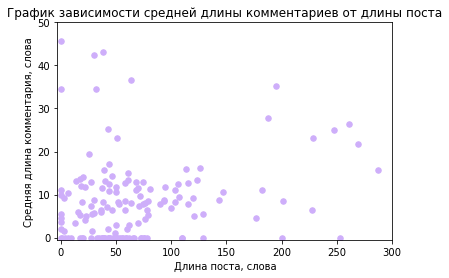

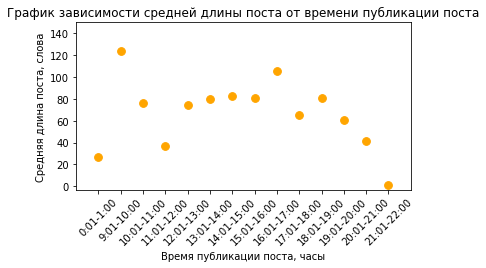

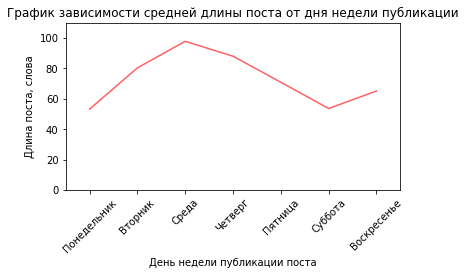

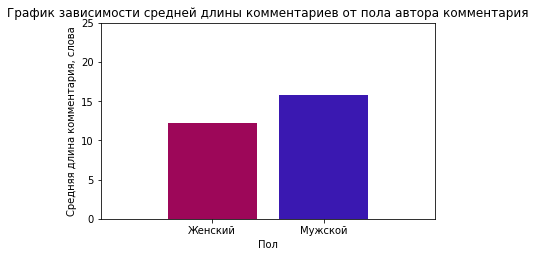

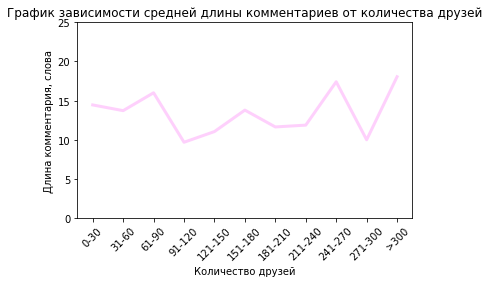

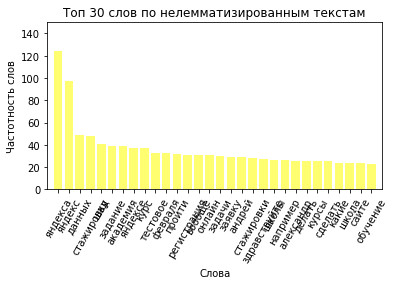

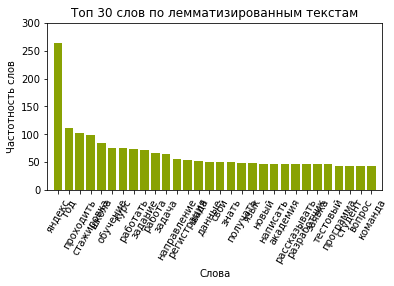

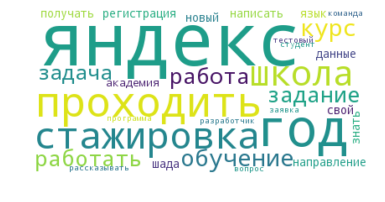

In [40]:
run_on_existing_data()

conn.close()